              Mtot   M_ratio    R_shift  log_likelihood  log_prior
0    337719.091219  0.324680   8.710130   276726.544665 -16.243847
1    106439.511209  0.672459   2.384380   276726.544665 -16.243847
2    219427.773696  0.648917   7.965272   276726.544665 -16.243847
3    236946.785508  0.224581   6.692308   276726.544665 -16.243847
4    123958.523021  0.248123   1.111416   276726.544665 -16.243847
..             ...       ...        ...             ...        ...
532  607695.053748  0.763773   7.951483   276726.544665 -16.243847
533  210909.296833  0.740600  13.000240   276726.544665 -16.243847
534  946393.857334  0.193809  10.344205   276726.544665 -16.243847
535  676473.148859  0.246391  12.674844   276726.544665 -16.243847
536  269726.885620  0.804870  13.348216   276726.544665 -16.243847

[537 rows x 5 columns]
0      337719.091219
1      106439.511209
2      219427.773696
3      236946.785508
4      123958.523021
           ...      
532    607695.053748
533    210909.296833
534 

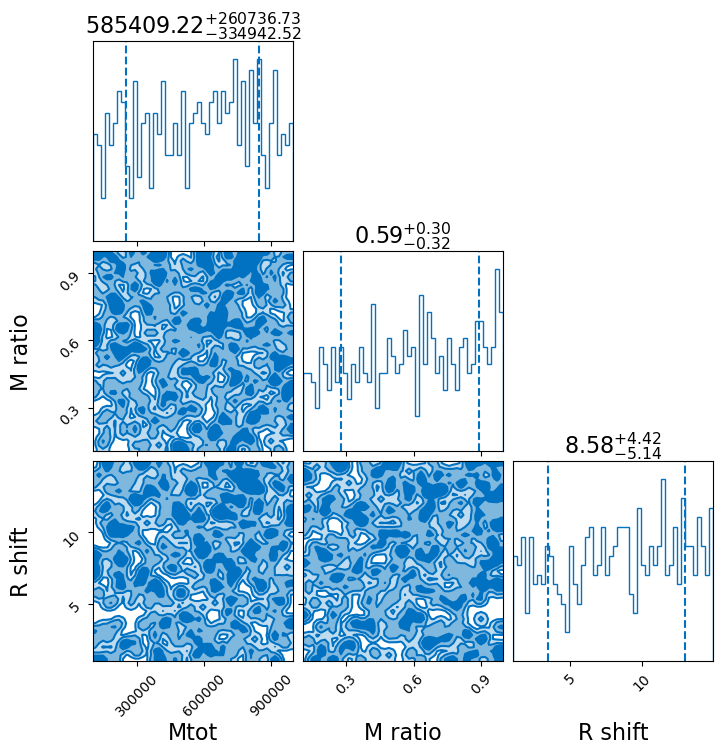

In [1]:
import bilby

# 指定保存的目录和文件名
result_file = "custom_model_output/result2/custom_model_result.json"

# 加载结果
result = bilby.result.read_in_result(result_file)

# 查看结果中的后验分布
print(result.posterior)

# 提取某个参数的后验分布
print(result.posterior["Mtot"])

# 查看最大似然估计
#print("Maximum Likelihood:", result.maximum_likelihood)

# 绘制角图（可视化）
result.plot_corner()


In [2]:
from KL import compute_kl_divergence
import bilby
result1 = bilby.result.read_in_result("custom_model_output/result1/custom_model_result.json")
result2 = bilby.result.read_in_result("custom_model_output/result2/custom_model_result.json")

sample1 = result1.posterior['Mtot']
sample2 = result2.posterior['Mtot']

# 计算 KL 散度
kl_div = compute_kl_divergence(sample1, sample2)
print(f"KL Divergence between the two distributions: {kl_div:.4f}")

KL Divergence between the two distributions: 0.0060


In [1]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
import numpy as np

def fftfilt(b, x):
    """Use FFT to apply FIR filter defined by b to signal x."""
    # 获取输入信号和滤波器的长度
    N_x = len(x)
    N_b = len(b)
    
    # 计算 FFT 的大小
    N = N_x + N_b - 1
    
    # 计算滤波器和输入信号的 FFT
    X = np.fft.fft(x, N)
    B = np.fft.fft(b, N)
    
    # 乘以滤波器的频率响应
    Y = X * B
    
    # 计算逆 FFT 以获得滤波后的信号
    y = np.fft.ifft(Y)
    
    # 取出中间的部分，与输入信号长度相同
    start = (N_b - 1) // 2
    y = y[start:start + N_x]
    
    # 只取实部（虚部应该非常接近零）
    return np.real(y)


def stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq):
    sqrt_PSD=np.sqrt(PSD)
    sqrt_PSD[-1]=0
    #b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    in_noise=np.random.randn(1,n_samp)
    # print(in_noise.shape,b.shape)
    # print(fftfilt(b,in_noise[0]).shape)
    return np.sqrt(samp_freq)*fftfilt(b,in_noise[0])
import numpy as np 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

def generate_noise_from_psd(N, freqVec, psd, sample_rate, num_noises=1,freq_range=[0,1], duration = None):
    #freqVec = np.linspace(0, sample_rate/2, len(psd))
    noises = np.zeros((num_noises, N))
    interpolated_asds = []
    for i in range(num_noises):
        WGN = np.random.randn(N)
        X = np.fft.rfft(WGN) / np.sqrt(N)
        asd = np.sqrt(psd)
        uneven = N % 2
        # Simulate the white noise of rFFT
        # X = (np.random.randn(N // 2 + 1 + uneven) + 1j * np.random.randn(N // 2 + 1 + uneven))
        
        selected_indices = np.where((freqVec >= freq_range[0]) & (freqVec <= freq_range[1]))[0]
        
        # Interpolate selected ASD values to match the length of X
        interp_asd = interp1d(freqVec[selected_indices],asd[selected_indices], kind='linear', bounds_error=False, fill_value="extrapolate")
        newFreqVec = np.fft.rfftfreq(N+uneven, d=1.0/sample_rate)
        interpolated_asd = interp_asd(newFreqVec)
        nonSelected_indices = np.where(~ ((newFreqVec> freq_range[0]) & (newFreqVec < freq_range[1])))[0]
        interpolated_asd[nonSelected_indices] = 1e-30
        # interpolated_asd[interpolated_asd<1e-30] = 1e-30

        # Apply the random ASD to create colored noise
        # In order to keep the nSample equal to before
        Y_colored = X * interpolated_asd
        y_colored = np.fft.irfft(Y_colored).real * np.sqrt(N*sample_rate)
        if uneven:
            y_colored = y_colored[:-1]
        
        noises[i, :] = y_colored 
        interpolated_asds.append(interpolated_asd)
        
    return noises, interpolated_asds


/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [4]:
import numpy as np
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from config.config import Config
from data.waveform import *
from data.ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import fftfilt, stat_gauss_noise,generate_noise_from_psd
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
import os
scale=Config.scale
samp_freq=Config.samp_freq
N=round(samp_freq/Config.f_step)
time_vec=1/samp_freq*np.arange(0,N,1)
Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
signal_length = Config.signal_length

para = [Mtot, M_ratio, R_shift]
freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
f_sf = sf(freq_ifft, para, para_dw, para_dtau)
st = Ga.Freq_ifft(f_sf)


In [5]:
index = int(1/2*len(st))
st=np.concatenate((st[index:], st[:index]))
PSD=PSD_Lisa_no_Response(freq_ifft)
out_noise, _ = generate_noise_from_psd(N,freq_ifft,PSD, sample_rate=samp_freq)

#print(len(out_noise[0]))
start1=int(1/2*(len(out_noise[0])-signal_length))
start2=int(1/2*(len(st)-signal_length))
#print(len(out_noise[0][start:start+signal_length]))
signal = st[start2:start2+signal_length]
signal=torch.tensor(signal)
signal=torch.real(signal)

noise=out_noise[0][start1:start1+signal_length]
noise=torch.tensor(noise)
noise=torch.real(noise)

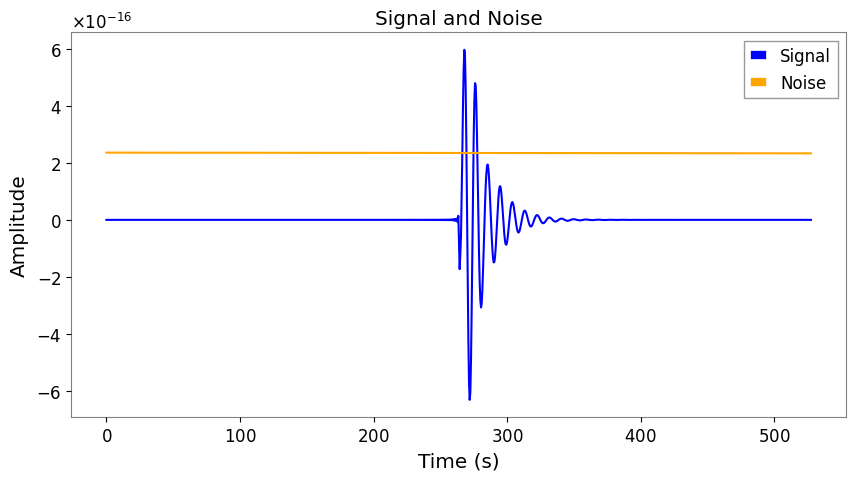

In [13]:
#绘制噪声曲线
plt.figure(figsize=(10, 5))
plt.plot(time_vec[:signal_length], signal.numpy(), label='Signal', color='blue')
plt.plot(time_vec[:signal_length], noise.numpy(), label='Noise', color='orange')
plt.title('Signal and Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

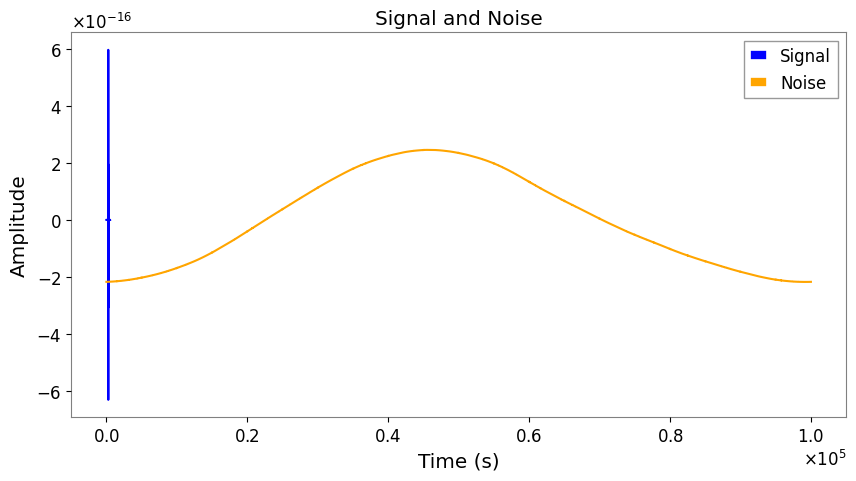

In [14]:
#绘制噪声曲线
plt.figure(figsize=(10, 5))
plt.plot(time_vec[:signal_length], signal.numpy(), label='Signal', color='blue')
plt.plot(time_vec, out_noise[0], label='Noise', color='orange')
plt.title('Signal and Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [7]:
print(noise)

tensor([2.3556e-16, 2.3552e-16, 2.3554e-16,  ..., 2.3298e-16, 2.3298e-16,
        2.3297e-16], dtype=torch.float64)
